In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans
from datetime import timedelta
from scipy.stats import f_oneway

# Mac的請取消註解下面
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] # 正常顯示中文標籤

# Windows的請取消註解下面
# import matplotlib
# matplotlib.rc('font', family='Microsoft JhengHei')

In [2]:
# 讀取 CSV 文件
dp001_exam = pd.read_csv('../2024初賽用開放資料/dp001_exam.csv')
dp001_prac = pd.read_csv('../2024初賽用開放資料/dp001_prac.csv')
dp001_review_plus = pd.read_csv('../2024初賽用開放資料/dp001_review_plus.csv')
dp001_review = pd.read_csv('../2024初賽用開放資料/dp001_review.csv')
dp002_exam = pd.read_csv('../2024初賽用開放資料/dp002_exam.csv')
dp003_math = pd.read_csv('../2024初賽用開放資料/dp003_math.csv')
dp003_word = pd.read_csv('../2024初賽用開放資料/dp003_word.csv')
user_data = pd.read_csv('../2024初賽用開放資料/user_data.csv')

user_data

,user_sn,organization_id,grade,class,seat,chinese_score,math_score,english_score
0,2697,973,5,2,12,80,52,86
1,4381,3740,5,7,18,70,52,57
2,4561,973,5,2,16,77,56,100
3,6802,973,5,2,15,93,60,49
4,6828,3740,5,7,27,83,52,89
...,...,...,...,...,...,...,...,...
90,312031,973,5,2,2,80,68,97
91,313378,2486,5,1,7,37,36,34
92,313897,338,5,3,10,73,64,89
93,314389,338,5,3,1,87,68,97


In [3]:
# 有這些科目
dp001_prac['subject_name'].unique()

array(['自然108', '國語文108', '數學108', '數學', nan, '防災', '英語108', '表演藝術',
       '國語文', '音樂', '海洋與環境', '健康與體育', '視覺藝術', '自然', '資訊教育'], dtype=object)

In [ ]:
merged_data = pd.merge(dp001_prac, user_data, on='user_sn', how='left') # 合併兩個 DataFrame
filtered_data = merged_data[merged_data['subject_name'].isin(['國語文108', '數學108', '數學', '英語108', '國語文'])]

In [49]:
# 統整同個 review_sn 並統計 view_action
action_counts = dp001_review_plus.groupby(['review_sn', 'view_action']).size().unstack(fill_value=0)

# 統計每個 review_sn 的總 view_action 次數
total = action_counts.sum(axis=1).reset_index()
total.columns = ['review_sn', 'total_view_actions']

# 將 total 加到 dp001_review 裡面，靠著 review_sn 合併
dp001_review_total = dp001_review.merge(total, on='review_sn', how='left')

review_data = pd.merge(dp001_review_total, user_data, on='user_sn', how='left') # 合併兩個 DataFrame
review_data = review_data[review_data['subject_name'].isin(['數學108', '數學'])] # 篩選數學文科目

review_data['start_time'] = pd.to_datetime(review_data['start_time']) # 轉換時間格式
review_data['end_time'] = pd.to_datetime(review_data['end_time']) # 轉換時間格式
review_data['duration'] = review_data['end_time'] - review_data['start_time'] # 計算觀看時間
review_data['date'] = review_data['start_time'].dt.date # 取得日期

# 計算每天的觀看時間
duration_per_user_per_date = review_data.groupby(['user_sn', 'date']).agg({'duration': 'sum', 'total_view_actions': 'sum'}).reset_index()
duration_per_user_per_date

,user_sn,date,duration,total_view_actions
0,8634,2024-02-16,0 days 00:16:06,12
1,8634,2024-02-20,0 days 00:39:15,169
2,8634,2024-03-04,0 days 00:21:33,9
3,8634,2024-03-08,0 days 02:05:00,33
4,8634,2024-03-11,0 days 00:26:59,30
...,...,...,...,...
624,314389,2024-05-07,0 days 00:35:00,69
625,314389,2024-05-20,0 days 00:21:27,47
626,314389,2024-05-21,0 days 00:19:17,50
627,316786,2024-02-28,0 days 00:23:37,43


In [50]:
# 計算每個 user_sn 的 total_view_actions 總和
total_view_actions_per_user = duration_per_user_per_date.groupby('user_sn')['total_view_actions'].sum().reset_index()
total_view_actions_per_user.columns = ['user_sn', 'total_view_actions_sum']

# 計算每個 user_sn 擁有的 review_sn 數量
review_counts = dp001_review.groupby('user_sn')['review_sn'].nunique().reset_index()
review_counts.columns = ['user_sn', 'review_count']
review_counts

# # 將 review_count 加到 dp001_review 裡面，靠著 user_sn 合併
total_view_actions_per_user_new = total_view_actions_per_user.merge(review_counts, on='user_sn', how='left')
# 計算平均每部影片的操作動作數量
total_view_actions_per_user_new['avg_actions_per_review'] = total_view_actions_per_user_new['total_view_actions_sum'] / total_view_actions_per_user_new['review_count']
total_view_actions_per_user_new

,user_sn,total_view_actions_sum,review_count,avg_actions_per_review
0,8634,289,50,5.780000
1,11303,161,63,2.555556
2,11312,510,44,11.590909
3,13328,185,80,2.312500
4,14503,1665,65,25.615385
5,15995,1929,76,25.381579
6,17422,7,5,1.400000
7,20034,298,82,3.634146
8,23250,411,73,5.630137
9,32737,1278,66,19.363636


# feature

In [51]:
data = duration_per_user_per_date
scores = user_data

# 1. Convert date format and calculate the study interval for each user
data['date'] = pd.to_datetime(data['date'])
data['duration'] = pd.to_timedelta(data['duration'])

# 2. Calculate the study interval and total duration for each student
data['day_diff'] = data.groupby('user_sn')['date'].diff().dt.days
interval_std = data.groupby('user_sn')['day_diff'].std()  # Standard deviation of study intervals
total_duration = data.groupby('user_sn')['duration'].sum()  # Total study duration

# 3. Clustering: Use standard deviation and total duration as features for clustering
features = pd.DataFrame({'interval_std': interval_std, 'total_duration': total_duration})
features['total_duration'] = features['total_duration'].dt.total_seconds()  # Convert to seconds
features = features.merge(total_view_actions_per_user_new, on='user_sn', how='left') # Merge total view actions

# Remove samples with missing values
features = features.dropna()
features



,user_sn,interval_std,total_duration,total_view_actions_sum,review_count,avg_actions_per_review
0,8634,9.633276,14792.0,289,50,5.780000
1,11303,8.211780,13961.0,161,63,2.555556
2,11312,23.334524,3748.0,510,44,11.590909
3,13328,8.368260,16481.0,185,80,2.312500
4,14503,7.018725,36012.0,1665,65,25.615385
5,15995,6.935746,52504.0,1929,76,25.381579
7,20034,9.840635,20257.0,298,82,3.634146
8,23250,7.501515,11918.0,411,73,5.630137
9,32737,5.294098,24644.0,1278,66,19.363636
11,38614,9.093531,34269.0,2320,67,34.626866


# kmeans

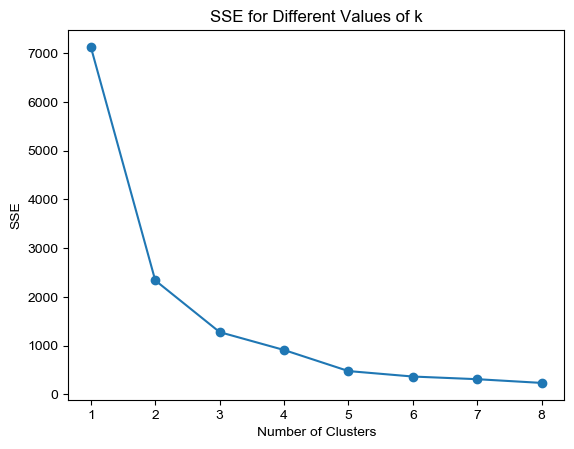

各群 math_score 均值：
 cluster
0    44.923077
1    40.842105
2    54.666667
3    28.000000
4    57.666667
Name: math_score, dtype: float64
各群 math_score 中位數：
 cluster
0    44.0
1    40.0
2    48.0
3    28.0
4    62.0
Name: math_score, dtype: float64
各群 math_score 標準差：
 cluster
0    15.418936
1    13.635180
2    15.143756
3          NaN
4    17.095099
Name: math_score, dtype: float64
各群 math_score 數量：
 cluster
0    13
1    19
2     3
3     1
4    12
Name: math_score, dtype: int64
F-statistic: 2.9140047434761143, P-value: 0.0321652850763568
There is a significant difference in math scores between different clusters.


In [52]:

SSE = []  # Sum of Squared Error
for k in range(1, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    features['cluster'] = kmeans.fit_predict(features[['interval_std', 'avg_actions_per_review']])
    features
    SSE.append(kmeans.inertia_)
y_pos  = np.arange(1,9)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('SSE for Different Values of k')
plt.plot(y_pos , SSE, 'o-')
plt.show()
# Use K-means for clustering into two categories
kmeans = KMeans(n_clusters=5, random_state=42)
features['cluster'] = kmeans.fit_predict(features[['interval_std', 'avg_actions_per_review']])

# Merge the cluster labels with the user data to get math scores
result = features.merge(user_data[['user_sn', 'math_score']], on='user_sn', how='left')

cluster_means = result.groupby('cluster')['math_score'].mean()
print("各群 math_score 均值：\n", cluster_means)
cluster_medians = result.groupby('cluster')['math_score'].median()
print("各群 math_score 中位數：\n", cluster_medians)
cluster_std = result.groupby('cluster')['math_score'].std()
print("各群 math_score 標準差：\n", cluster_std)
cluster_counts = result.groupby('cluster')['math_score'].count()
print("各群 math_score 數量：\n", cluster_counts)

# Use ANOVA to test whether there are significant differences in math_score between different clusters
grouped_scores = [group['math_score'].values for name, group in result.groupby('cluster')]
f_stat, p_value = f_oneway(*grouped_scores)
print(f"F-statistic: {f_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference in math scores between different clusters.")
else:
    print("There is no significant difference in math scores between different clusters.")


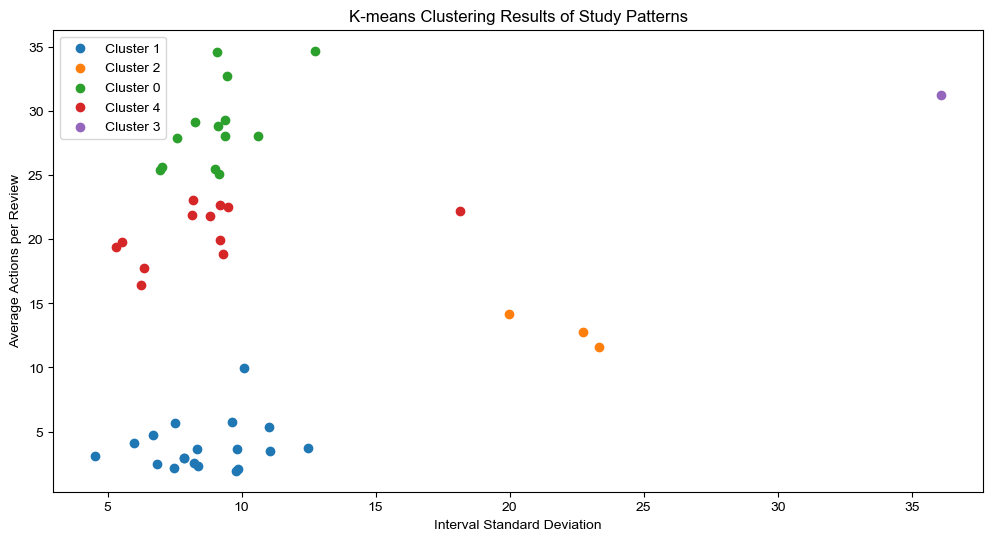

In [53]:
# 繪製 K-means 分群結果
plt.figure(figsize=(12, 6))
for cluster in features['cluster'].unique():
    cluster_data = features[features['cluster'] == cluster]
    # plt.scatter(cluster_data['interval_std'], cluster_data['total_duration'], label=f'Cluster {cluster}')
    plt.scatter(cluster_data['interval_std'], cluster_data['avg_actions_per_review'], label=f'Cluster {cluster}')
    plt.xlabel('Interval Standard Deviation')
    plt.ylabel('Average Actions per Review')
    plt.title('K-means Clustering Results of Study Patterns')
    plt.legend()
plt.show()